In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data_path = "Face Mask Dataset"

def load_images_labels(data_path, folder):
    images = []
    labels = []
    folder_path = os.path.join(data_path, folder)

    for label in ['WithMask', 'WithoutMask']:
        label_folder_path = os.path.join(folder_path, label)
        for img_file in os.listdir(label_folder_path):
            img_path = os.path.join(label_folder_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128)) / 255.0
            images.append(img)
            labels.append(0 if label == 'WithMask' else 1)
    
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_labels(data_path, 'Train')
val_images, val_labels = load_images_labels(data_path, 'Validation')
test_images, test_labels = load_images_labels(data_path, 'Test')
t_img, t_labels = load_images_labels(data_path, 'Multiple Test Images')

In [3]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                                 
                                                        

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    batch_size=32,
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
313/313 [==============================] - 5s 14ms/step - loss: 0.1292 - accuracy: 0.9803 - val_loss: 0.2055 - val_accuracy: 0.9588
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0343 - accuracy: 0.9893 - val_loss: 0.0673 - val_accuracy: 0.9875
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0300 - accuracy: 0.9912 - val_loss: 0.0617 - val_accuracy: 0.9912
Epoch 4/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0356 - accuracy: 0.9923 - val_loss: 0.1490 - val_accuracy: 0.9675
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0284 - accuracy: 0.9917 - val_loss: 0.0231 - val_accuracy: 0.9950
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0192 - accuracy: 0.9952 - val_loss: 0.0260 - val_accuracy: 0.9925
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 0.0103 - accuracy: 0.9958 - val_loss: 0.0479 - val_accuracy: 0.9912

31/31 [==============================] - 0s 10ms/step - loss: 0.0506 - accuracy: 0.9889
Test accuracy: 98.89%
31/31 [==============================] - 0s 4ms/step


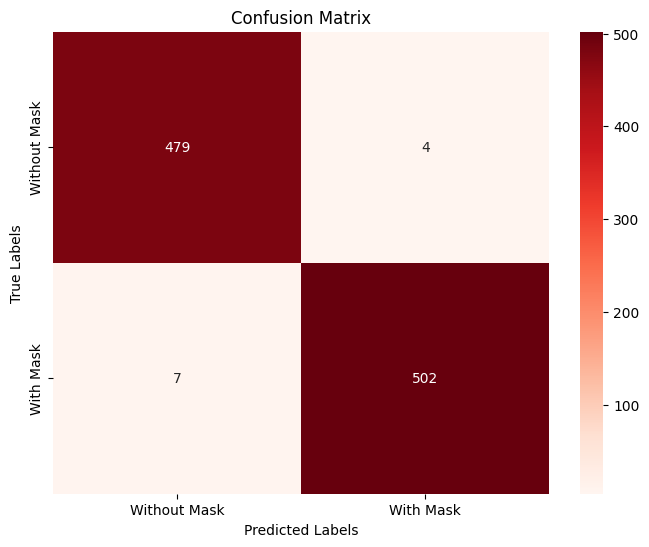

              precision    recall  f1-score   support

Without Mask       0.99      0.99      0.99       483
   With Mask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [7]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Generate predictions
pred_probs = model.predict(test_images)  
pred_labels = (pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Display confusion matrix and classification report
cm = confusion_matrix(test_labels, pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Without Mask', 'With Mask'], yticklabels=['Without Mask', 'With Mask'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


report = classification_report(test_labels, pred_labels, target_names=['Without Mask', 'With Mask'])
print(report)


In [8]:
# Load pre-trained face detection model (Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect and crop faces
def detect_and_crop_faces(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert image to grayscale for face detection
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    face_crops = []
    for (x, y, w, h) in faces:
        face_crop = img[y:y+h, x:x+w]  # Crop the face from the original image
        face_crops.append(face_crop)
    
    return face_crops

1/1 [==============================] - 0s 228ms/step


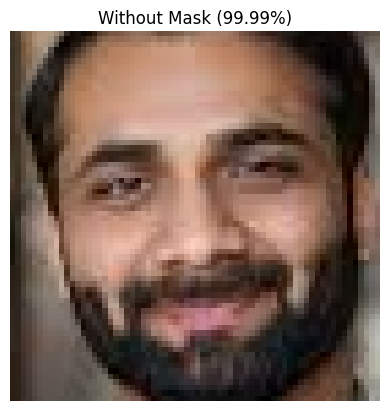

In [16]:
mask_img_path = r'Face Mask Dataset\Multiple Test Images\download (1).jpg'
nomask_img_path = r'Face Mask Dataset\Multiple Test Images\WithoutMask\images (4).jpg'
sample_img = cv2.imread(nomask_img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Detect faces and crop them
faces = detect_and_crop_faces(sample_img)

if len(faces) == 0:
    print("No faces detected.")
else:
    for i, face in enumerate(faces):
        # Resize and normalize the cropped face
        face_resized = cv2.resize(face, (128, 128)) / 255.0
        face_expanded = np.expand_dims(face_resized, axis=0)

        # Make a prediction on the cropped face
        pred = model.predict(face_expanded)
        
        # Label and confidence calculation
        label = (pred > 0.5).astype(int).flatten()[0]
        confidence = pred[0][0] * 100 if label == 1 else (1 - pred[0][0]) * 100
        label_text = 'With Mask' if label == 0 else 'Without Mask'
        
        # Plot each detected face with its prediction
        plt.subplot(1, len(faces), i+1)
        plt.imshow(face)
        plt.title(f"{label_text} ({confidence:.2f}%)")
        plt.axis('off')

    plt.show()

In [15]:
model.save('face_mask_detector.keras')
new_model = tf.keras.models.load_model(r'C:\Users\Bala Vignesh\ML Coding\Face Mask Detection\face_mask_detector.keras')
new_model.summary()

loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                                 
                                                        